# MNIST classification
- with a linear network
- https://en.wikipedia.org/wiki/MNIST_database

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sklearn

print('numpy: ', np.__version__)
print('sklearn: ', sklearn.__version__)

plt.style.use('seaborn-whitegrid')

numpy:  1.18.2
sklearn:  0.22.2.post1


In [0]:
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torch.utils
import torch.nn as nn
import torch.optim
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')
print (device)

cuda:0


## Data Preparation

In [0]:
data_transform = torchvision.transforms.Compose([#transforms.Grayscale(), 
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Lambda(lambda im: im.reshape(-1))
                                    ])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
mnist_test  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)

batch_size=4
train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

Text(0.5, 1.0, 'label: 5')

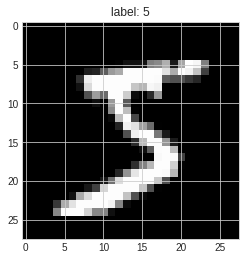

In [5]:
# Explore
im, label = mnist_train[0]
plt.imshow(im.reshape(28,28), cmap='gray')
plt.title(f'label: {label}')

torch.Size([4, 784])


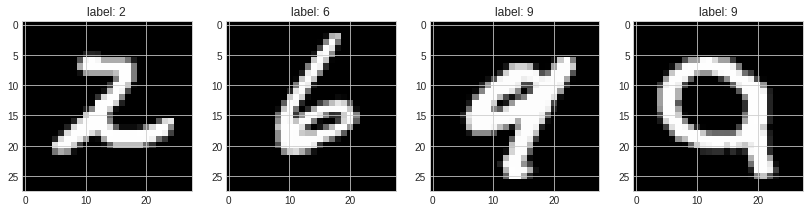

In [6]:
for batch_im, batch_label in train:
    print(batch_im.shape)
    fig, axes = plt.subplots(1,batch_im.shape[0], figsize=(14,8))
    for i in range(batch_im.shape[0]):
        axes[i].imshow(batch_im[i].reshape(28,28), cmap='gray')
        axes[i].set_title(f'label: {batch_label[i]}')
    break

## Training Loop

In [0]:
def performance(model, loss_fn, dataloader):
    model.eval()
    with torch.no_grad():
        loss, acc, n = 0., 0., 0.
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            ypred = model(x)
            loss += loss_fn(ypred, y).item() * len(y)
            p = torch.argmax(ypred, dim=1)
            acc += (p == y).sum().item()
            n += len(y)
        #
    loss /= n
    acc /= n
    return loss, acc
  
def training_loop(n_epochs, optim, model, loss_fn, dl_train, dl_val, hist=None):
    if hist is not None:
        pass
    else:
        hist = {'tloss': [], 'tacc': [], 'vloss': [], 'vacc': []}
        
    for epoch in range(1, n_epochs+1):
        tr_loss, tr_acc = 0., 0.
        n_data = 0
        for im_batch, label_batch in dl_train: # minibatch
            im_batch, label_batch = im_batch.to(device), label_batch.to(device)
            ypred = model(im_batch)
            loss_train = loss_fn(ypred, label_batch)
        
            optim.zero_grad()
            loss_train.backward()
            optim.step()

            
            # accumulate correct prediction
            tr_acc  += (torch.argmax(ypred.detach(), dim=1) == label_batch).sum().item() # number of correct predictions
            tr_loss += loss_train.item() * im_batch.shape[0]
            n_data  += im_batch.shape[0]
        #
        # statistics
        tr_loss /= n_data
        tr_acc  /= n_data
        #
        val_loss, val_acc = performance(model, loss_fn, dl_val)
        
        if epoch <= 5 or epoch % 10 == 0 or epoch == n_epochs:
             print(f'Epoch {epoch}, tloss {tr_loss:.2f} t_acc: {tr_acc:.4f}  vloss {val_loss:.2f}  v_acc: {val_acc:.4f}')
            
        # record for history return
        hist['tloss'].append(tr_loss)
        hist['vloss'].append(val_loss) 
        hist['tacc'].append(tr_acc)
        hist['vacc'].append(val_acc)
        
    print ('finished training_loop().')
    return hist

## Model with Two Linear Blocks

In [0]:
class LinearBlock(nn.Module):
    def __init__(self, in_features, out_features, activation = 'tanh'):
        super().__init__()
        
        self.Linear = nn.Linear(in_features = in_features, out_features = out_features)
        self.BatchNorm = nn.BatchNorm1d(out_features)

        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Tanh()

    def forward(self, input):
        linear = self.Linear(input)
        batchnorm = self.BatchNorm(linear)
        activation = self.activation(batchnorm)

        return activation


class MNISTNetwork(nn.Module):
    def __init__(self, n_features, n_target, activation = 'tanh'):
        super().__init__()
        
        self.Hidden_1 = LinearBlock(n_features, n_features//2 ,activation = activation)  
        self.Hidden_2 = LinearBlock(n_features//2, n_features//4, activation = activation)  
        self.Linear = nn.Linear(n_features//4, n_target)
        self.activation = nn.LogSoftmax(dim = 1)

    def forward(self, input):
        Hidden_1 = self.Hidden_1(input)
        Hidden_2 = self.Hidden_2(Hidden_1)
        Linear = self.Linear(Hidden_2)
        Softmax = self.activation(Linear)

        return Softmax

In [8]:
in_features = 28*28
n_target = 10

net = MNISTNetwork(in_features, n_target).to(device)
net

MNISTNetwork(
  (Hidden_1): LinearBlock(
    (Linear): Linear(in_features=784, out_features=392, bias=True)
    (BatchNorm): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): Tanh()
  )
  (Hidden_2): LinearBlock(
    (Linear): Linear(in_features=392, out_features=196, bias=True)
    (BatchNorm): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): Tanh()
  )
  (Linear): Linear(in_features=196, out_features=10, bias=True)
  (activation): LogSoftmax()
)

In [0]:
batch_size=128
data_loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

### Model with SGD & Tanh

In [0]:
model_1 = MNISTNetwork(in_features, n_target).to(device)

sgd = torch.optim.SGD(model_1.parameters(), lr=1e-2)

loss_fn = nn.NLLLoss().to(device)

In [12]:
history = training_loop(n_epochs=30,
                        optim=sgd,
                        model=model_1,
                        loss_fn=loss_fn, 
                        dl_train=data_loader_train,
                        dl_val = data_loader_test)

Epoch 1, tloss 0.56 t_acc: 0.8649  vloss 0.33  v_acc: 0.9139
Epoch 2, tloss 0.29 t_acc: 0.9204  vloss 0.25  v_acc: 0.9314
Epoch 3, tloss 0.23 t_acc: 0.9360  vloss 0.21  v_acc: 0.9418
Epoch 4, tloss 0.19 t_acc: 0.9455  vloss 0.18  v_acc: 0.9467
Epoch 5, tloss 0.17 t_acc: 0.9533  vloss 0.16  v_acc: 0.9534
Epoch 10, tloss 0.09 t_acc: 0.9749  vloss 0.11  v_acc: 0.9684
Epoch 20, tloss 0.04 t_acc: 0.9919  vloss 0.07  v_acc: 0.9769
Epoch 30, tloss 0.02 t_acc: 0.9978  vloss 0.07  v_acc: 0.9790
finished training_loop().


In [0]:
def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(16,4))
    axes[0].set_title('Loss'); 
    axes[0].plot(history['tloss'], label='train'); axes[0].plot(history['vloss'], label='val')
    axes[0].legend()
    axes[1].set_title(f'Acc, Maximum Acc : {max(history["vacc"])}')
    axes[1].plot(history['tacc'], label='train'); axes[1].plot(history['vacc'], label='val')
    axes[1].legend()

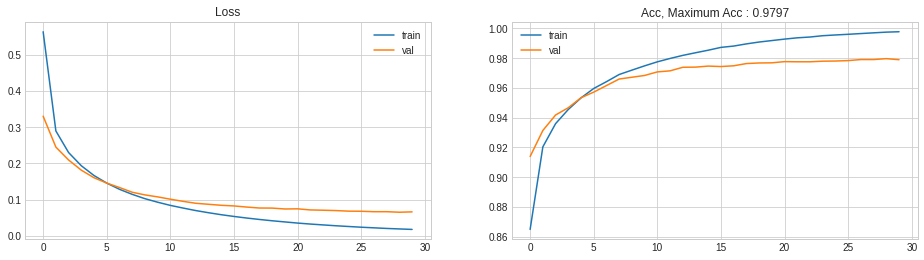

In [14]:
plot_history(history)

### Model with SGD & ReLU

In [0]:
model_2 = MNISTNetwork(in_features, n_target, activation = 'relu').to(device)

sgd = torch.optim.SGD(model_2.parameters(), lr=1e-2)
# sgd는 작은 learning rate로도 빨리 수렴을 했음 (경험적 결과)
# 그러나 global minimum 이 아닌 local minimum으로 수렴하는 듯한 결과를 보임
loss_fn = nn.NLLLoss().to(device)

In [16]:
history = training_loop(n_epochs=30,
                        optim=sgd,
                        model=model_2,
                        loss_fn=loss_fn, 
                        dl_train=data_loader_train,
                        dl_val = data_loader_test)

Epoch 1, tloss 0.57 t_acc: 0.8754  vloss 0.26  v_acc: 0.9370
Epoch 2, tloss 0.20 t_acc: 0.9433  vloss 0.16  v_acc: 0.9538
Epoch 3, tloss 0.14 t_acc: 0.9586  vloss 0.13  v_acc: 0.9604
Epoch 4, tloss 0.11 t_acc: 0.9674  vloss 0.11  v_acc: 0.9660
Epoch 5, tloss 0.09 t_acc: 0.9722  vloss 0.10  v_acc: 0.9700
Epoch 10, tloss 0.05 t_acc: 0.9873  vloss 0.07  v_acc: 0.9770
Epoch 20, tloss 0.02 t_acc: 0.9971  vloss 0.06  v_acc: 0.9791
Epoch 30, tloss 0.01 t_acc: 0.9996  vloss 0.06  v_acc: 0.9803
finished training_loop().


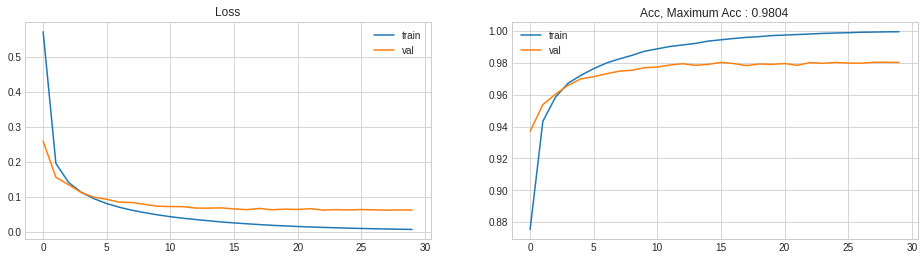

In [17]:
plot_history(history)

### Model with Adam & Tanh

In [0]:
model_3 = MNISTNetwork(in_features, n_target).to(device)

adam = torch.optim.Adam(model_3.parameters(), lr=1e-4)

In [26]:
history = training_loop(n_epochs=30,
                        optim=adam,
                        model=model_3,
                        loss_fn=loss_fn, 
                        dl_train=data_loader_train,
                        dl_val = data_loader_test)

Epoch 1, tloss 0.50 t_acc: 0.8813  vloss 0.28  v_acc: 0.9274
Epoch 2, tloss 0.22 t_acc: 0.9387  vloss 0.18  v_acc: 0.9493
Epoch 3, tloss 0.15 t_acc: 0.9568  vloss 0.14  v_acc: 0.9598
Epoch 4, tloss 0.11 t_acc: 0.9681  vloss 0.12  v_acc: 0.9669
Epoch 5, tloss 0.09 t_acc: 0.9766  vloss 0.10  v_acc: 0.9713
Epoch 10, tloss 0.02 t_acc: 0.9958  vloss 0.07  v_acc: 0.9787
Epoch 20, tloss 0.00 t_acc: 1.0000  vloss 0.07  v_acc: 0.9807
Epoch 30, tloss 0.00 t_acc: 1.0000  vloss 0.08  v_acc: 0.9830
finished training_loop().


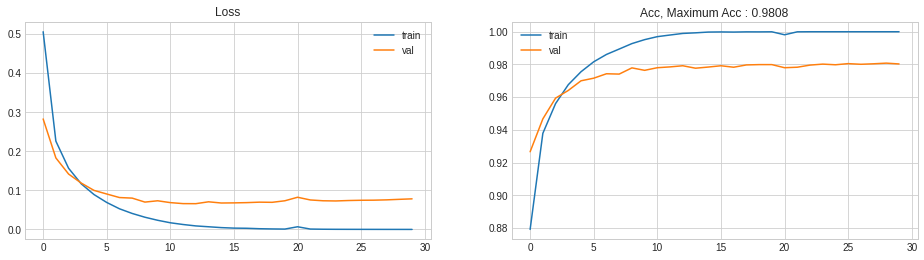

In [20]:
plot_history(history)

### Model with Adam & ReLU

In [0]:
model_4 = MNISTNetwork(in_features, n_target, activation = 'relu').to(device)

adam = torch.optim.Adam(model_4.parameters(), lr=1e-4)

In [22]:
history = training_loop(n_epochs=30,
                        optim=adam,
                        model=model_4,
                        loss_fn=loss_fn, 
                        dl_train=data_loader_train,
                        dl_val = data_loader_test)

Epoch 1, tloss 0.53 t_acc: 0.8839  vloss 0.22  v_acc: 0.9487
Epoch 2, tloss 0.14 t_acc: 0.9583  vloss 0.12  v_acc: 0.9653
Epoch 3, tloss 0.09 t_acc: 0.9726  vloss 0.10  v_acc: 0.9709
Epoch 4, tloss 0.07 t_acc: 0.9806  vloss 0.08  v_acc: 0.9759
Epoch 5, tloss 0.05 t_acc: 0.9857  vloss 0.07  v_acc: 0.9772
Epoch 10, tloss 0.01 t_acc: 0.9973  vloss 0.07  v_acc: 0.9799
Epoch 20, tloss 0.00 t_acc: 1.0000  vloss 0.07  v_acc: 0.9821
Epoch 30, tloss 0.00 t_acc: 1.0000  vloss 0.09  v_acc: 0.9810
finished training_loop().


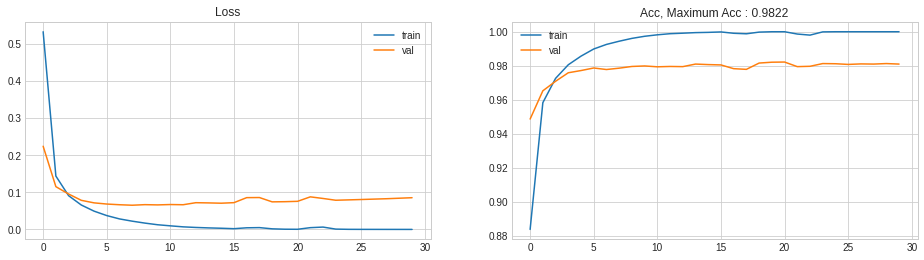

In [23]:
plot_history(history)